In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/unet_qr_steganography
# !pip install kornia pytorch_msssim

In [2]:
DEVICE='cuda'

## **Unet architect**

- https://www.mdpi.com/2079-9292/12/18/3808

In [3]:
import torch
import torch.nn as nn

torch.manual_seed(0)

In [4]:
class Conv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, **kwargs):
        super().__init__()

        self.layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, **kwargs),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU()
        )

    def forward(self, x):
        return self.layer(x)

In [5]:
class ExtractionBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = Conv(in_channels, out_channels, kernel_size=1)
        self.conv3 = nn.Sequential(
            Conv(in_channels, out_channels, kernel_size=3, padding=1),
            Conv(out_channels, out_channels, kernel_size=3, padding=1)
        )

    def forward(self, x):
        return self.conv1(x) + self.conv3(x)

class UpExtractionBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.transpose = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.extract = ExtractionBlock(out_channels*2, out_channels)

    def forward(self, x, concat):
        x = torch.concat([self.transpose(x), concat], dim=1)
        x = self.extract(x)
        return x



In [6]:
class Unet(nn.Module):
    def __init__(self, in_channels):
        super().__init__()

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.extract1 = ExtractionBlock(in_channels, 64)
        self.extract2 = ExtractionBlock(64, 128)
        self.extract3 = ExtractionBlock(128, 256)
        self.extract4 = ExtractionBlock(256, 512)

        self.extract4_1 = ExtractionBlock(512, 512)
        self.extract4_2 = ExtractionBlock(1024,512)

        self.extract5 = UpExtractionBlock(512, 256)
        self.extract6 = UpExtractionBlock(256, 128)
        self.extract7 = UpExtractionBlock(128, 64)

        self.layer = nn.Sequential(
            nn.Conv2d(64, 1, kernel_size=1),
            nn.Tanh()
        )

    def forward(self, x):
        x1 = self.extract1(x)
        x2 = self.extract2(self.pool(x1))
        x3 = self.extract3(self.pool(x2))
        x4 = self.extract4(self.pool(x3))

        x5 = self.extract4_1(x4)
        x  = torch.concat([x5, x4], dim=1)
        x  = self.extract4_2(x)
        x  = self.extract5(x, x3)
        x  = self.extract6(x, x2)
        x  = self.extract7(x, x1)

        return (self.layer(x) + 1) / 2


## **Processing Dataset**
- https://www.kaggle.com/datasets/tornikeonoprishvili/pepe-memes-dataaset

In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import glob
import kornia

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, root, image_size):
        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.PILToTensor()
        ])
        self.paths = glob.glob(f'{root}/*.jpg')

    def __getitem__(self, index):
        img = Image.open(self.paths[index])
        return self.transform(img).float()

    def __len__(self):
        return len(self.paths)

In [ ]:
def rgb_to_yuv(tensor):

    yuv = kornia.color.rgb_to_yuv(tensor)
    Y = yuv[:, 0:1, :, :]
    U = yuv[:, 1:2, :, :]
    V = yuv[:, 2:3, :, :]

    return Y, U, V

def yuv_to_rgb(Y, U, V):

    yuv_merged = torch.cat([Y, U, V], dim=1)
    rgb = kornia.color.yuv_to_rgb(yuv_merged)

    return rgb

## **Loss Functions**

In [10]:
from pytorch_msssim import ms_ssim, ssim
from torchvision.models import vgg16, VGG16_Weights

In [11]:
class VGG16PerceptualLoss(nn.Module):
    def __init__(self, layer=16):
        super().__init__()
        vgg = vgg16(weights=VGG16_Weights.DEFAULT).to(DEVICE).features
        self.feature_extractor = nn.Sequential(*list(vgg.children())[:layer+1]).eval()
        for param in self.feature_extractor.parameters():
            param.requires_grad = False
        self.mean = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1).to(DEVICE)
        self.std = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1).to(DEVICE)

    def forward(self, input, target):
        if input.shape[1] == 1:
            input = input.repeat(1, 3, 1, 1)
            target = target.repeat(1, 3, 1, 1)
        input_norm = (input - self.mean) / self.std
        target_norm = (target - self.mean) / self.std

        feat_input = self.feature_extractor(input_norm)
        feat_target = self.feature_extractor(target_norm)

        loss = nn.functional.l1_loss(feat_input, feat_target)
        return loss



class Loss(nn.Module):
    def __init__(self, alpha, beta):
        super().__init__()
        self.alpha = alpha
        self.beta  = beta
        self.ppl_loss = VGG16PerceptualLoss()

    def forward(self, c1, c2):
        return self.alpha * (1 - (ms_ssim(c1, c2, data_range=1))) + (1-self.alpha) * (1 - (ssim(c1,c2, data_range=1))) + self.beta * self.ppl_loss(c1, c2)


## **Traning**

In [12]:
def xavier_init_weights(m):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0.01)

In [13]:
from torch.optim.lr_scheduler import MultiStepLR
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [14]:
batch_size = 8
learning_rate = 0.0001
alpha = 0.5
beta = 0.85
epochs = 50
image_size = 200

In [ ]:
dataset       = ImageDataset(root='pepe_dataset', image_size=image_size)
cover_loader  = DataLoader(dataset, batch_size=batch_size, shuffle=True)
secret_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [ ]:
H = Unet(2).to(DEVICE)
E = Unet(3).to(DEVICE)

H.apply(xavier_init_weights)
E.apply(xavier_init_weights)

criterion = Loss(alpha, beta)
optimizer = torch.optim.Adam(list(H.parameters())+list(E.parameters()), lr=learning_rate)


milestones = list(range(15, epochs, 3))
scheduler = MultiStepLR(optimizer, milestones=milestones, gamma=0.5)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 198MB/s]


In [ ]:
x, y1, y2 = [], [], []

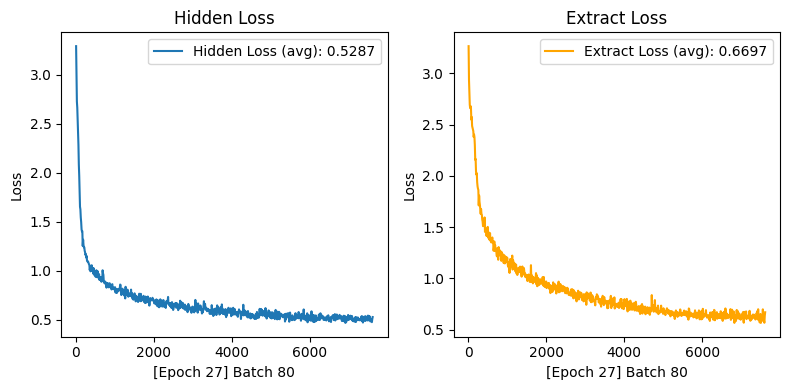

KeyboardInterrupt: 

In [ ]:
batch_hidden_losses = []
batch_extract_losses = []

for epoch in range(epochs):

    H.train()
    E.train()

    for i, (cover, secret) in enumerate(zip(cover_loader, secret_loader)):

        cover = cover.to(DEVICE) / 255.0
        secret = secret.to(DEVICE) / 255.0

        Y, U, V = rgb_to_yuv(cover)
        secret_Y, _, _ = rgb_to_yuv(secret)

        X = torch.concat([Y, secret_Y], dim=1)

        # 1. Hidden Network
        optimizer.zero_grad()

        stego = H(X)
        stego_rgb = yuv_to_rgb(stego, U, V)
        loss_hidden = criterion(cover, stego_rgb)

        # 2. Extract Network
        secret_Y_pred = E(stego_rgb)
        loss_extract = criterion(secret_Y, secret_Y)

        # Optimizer 
        loss = loss_hidden + 1.2 * (loss_extract.item() / loss_hidden.item()) * loss_extract
        loss.backward()
        optimizer.step()


        batch_hidden_losses.append(loss_hidden.item())
        batch_extract_losses.append(loss_extract.item())

        if (i + 1) % 10 == 0:

            avg_hidden_loss = sum(batch_hidden_losses) / len(batch_hidden_losses)
            avg_extract_loss = sum(batch_extract_losses) / len(batch_extract_losses)

            x.append(epoch * len(cover_loader) + i)
            y1.append(avg_hidden_loss)
            y2.append(avg_extract_loss)

            batch_hidden_losses = []
            batch_extract_losses = []

            clear_output(wait=True)
            plt.figure(figsize=(8, 4))

            plt.subplot(1, 2, 1)
            plt.plot(x, y1, label=f'Hidden Loss (avg): {avg_hidden_loss:.4f}')
            plt.title('Hidden Loss')
            plt.xlabel(f'[Epoch {epoch+1}] Batch {i+1}')
            plt.ylabel('Loss')
            plt.legend()

            plt.subplot(1, 2, 2)
            plt.plot(x, y2, label=f'Extract Loss (avg): {avg_extract_loss:.4f}', color='orange')
            plt.title('Extract Loss')
            plt.xlabel(f'[Epoch {epoch+1}] Batch {i+1}')
            plt.ylabel('Loss')
            plt.legend()

            plt.tight_layout()
            plt.show()

    scheduler.step()


In [18]:
torch.save(H.state_dict(), 'H_epoch30.pth')
torch.save(E.state_dict(), 'E_epoch30.pth')